In [1]:
import numpy as np
import pandas as pd
import os
import math

from sas7bdat import SAS7BDAT
import datetime

pd.set_option('display.max_rows', 300, 'display.max_columns', 300)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import adabound
from pycox.evaluation.concordance import concordance_td
from sklearn.metrics import accuracy_score, roc_auc_score
from lifelines import KaplanMeierFitter, NelsonAalenFitter, AalenJohansenFitter

torch.cuda.is_available()

True

In [2]:
class RAdam(optim.Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

In [3]:
#dat = SAS7BDAT('D://CRDW/00. Data/cancer_c56_210713_a.sas7bdat').to_data_frame()
#dat = SAS7BDAT('D://CRDW/00. Data/ovary_1819_final_b.sas7bdat').to_data_frame()
dat = SAS7BDAT('D:/Cho Lab Dropbox/연구원별정리/이다혜/07 CRDW/00. Data/cancer_c56_210713_a.sas7bdat').to_data_frame()
X_dat = dat[['SEERCODE_1',
             'MODIF2_PHIS_HTN_YN_2YR',
             'MODIF2_PHIS_DEPR_YN_2YR',
             'MODIF2_PHIS_DM_YN_2YR',
             'MODIF_MRTL_YN_2YR',
             'drink_modif',
             'smok_modif2',
             'AGE_C',
             'histology',
             'FIGO_grp'
            ]]

X_dat['BMI_GRP2'] = np.where(dat['MODIF_VS2_BMI_2YR'] < 25, 1, 0)
X_dat['BMI_GRP2'] = np.where((dat['MODIF_VS2_BMI_2YR'] >= 25), 2, X_dat['BMI_GRP2'])
X_dat['STAY_DRTN_GRP'] = np.where(dat['STAY_DRTN'] >= 15, 1, 0)

time_dat = dat['M_TIME_VTE_1YR']
DIA_YEAR = dat['DIA_YEAR']

time_dat2 = np.int32(time_dat) - 1
ntime = len(np.unique(time_dat2))

contvar = ["AGE_C"]
catevar= X_dat.columns[[x not in contvar for x in X_dat.columns]]

X_dat2 = X_dat.copy()
X_dat2[catevar] = X_dat2[catevar].astype("category")
print(X_dat2.dtypes)

X_dat3 = pd.get_dummies(X_dat2, columns = catevar, drop_first = True)
fixed_dat = X_dat3.to_numpy()
print(fixed_dat.shape)

nsubject = fixed_dat.shape[0]
print(nsubject)

SEERCODE_1                 category
MODIF2_PHIS_HTN_YN_2YR     category
MODIF2_PHIS_DEPR_YN_2YR    category
MODIF2_PHIS_DM_YN_2YR      category
MODIF_MRTL_YN_2YR          category
drink_modif                category
smok_modif2                category
AGE_C                       float64
histology                  category
FIGO_grp                   category
BMI_GRP2                   category
STAY_DRTN_GRP              category
dtype: object
(1268, 27)
1268


<ipython-input-3-d6714cc88ac9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dat['BMI_GRP2'] = np.where(dat['MODIF_VS2_BMI_2YR'] < 25, 1, 0)
<ipython-input-3-d6714cc88ac9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dat['BMI_GRP2'] = np.where((dat['MODIF_VS2_BMI_2YR'] >= 25), 2, X_dat['BMI_GRP2'])
<ipython-input-3-d6714cc88ac9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [4]:
time_dat = dat['M_TIME_VTE_1YR']
event_dat = dat['CR_VTE_1YR']
DIA_YEAR = dat['DIA_YEAR']

time_dat2 = np.int32(time_dat) - 1
ntime = len(np.unique(time_dat2))
num_event = 2

In [5]:
'''
(1) Binary 변수: 한 번이라도 관측된 값이 있으면 그 값을 baseline으로 사용
OP_dat: 진단 후 1~12개월 째 수술 여부
TF_dat: 진단 후 1~12개월 째 수술 당시 수혈 여부
RT_dat: 진단 후 1~12개월 째 방사선 치료 여부
WBC
Hb
Plt
CA125
OP_surgery_other

(2) Continuous 변수: 전체 시점 총합을 baseline으로 사용
DOSE_dat: 진단 후 1~12개월 째 투약된 dose 양

(3) Categorical 변수: 관측된 가장 첫번째 시점의 값을 baseline으로 사용
OP_TIME_dat: 진단 후 1~12개월 째 받은 수술 시간 (해당 월)
CT_약제명_dat
Ddimer

'''
OP_surgery = dat[['OP{}'.format(i) + '_SURGERY_AREA' for i in range(1,13)]] #모형에 사용하지 않고 대신 op_surgery_other를 씀

## (1) Binary 변수
OP_dat = dat[['OP_{}'.format(i) for i in range(1,13)]]
TF_dat = dat[['OP_TF_MON{}'.format(i) for i in range(1,13)]]
RT_dat = dat[['RT_MON{}'.format(i) for i in range(1,13)]]

WBC_MIN_normal = np.where(dat[['minWBC_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
WBC_MAX_normal = np.where(dat[['maxWBC_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
WBC_MED_normal = np.where(dat[['medianWBC_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
WBC_MIN_abnormal = np.where(dat[['minWBC_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
WBC_MAX_abnormal = np.where(dat[['maxWBC_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
WBC_MED_abnormal = np.where(dat[['medianWBC_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)

Hb_MIN_normal = np.where(dat[['minHb_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
Hb_MAX_normal = np.where(dat[['maxHb_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
Hb_MED_normal = np.where(dat[['medianHb_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
Hb_MIN_abnormal = np.where(dat[['minHb_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
Hb_MAX_abnormal = np.where(dat[['maxHb_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
Hb_MED_abnormal = np.where(dat[['medianHb_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)

PLT_MIN_normal = np.where(dat[['minPLT_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
PLT_MAX_normal = np.where(dat[['maxPLT_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
PLT_MED_normal = np.where(dat[['medianPLT_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
PLT_MIN_abnormal = np.where(dat[['minPLT_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
PLT_MAX_abnormal = np.where(dat[['maxPLT_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
PLT_MED_abnormal = np.where(dat[['medianPLT_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)

CA125_MIN_normal = np.where(dat[['minCA125_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
CA125_MAX_normal = np.where(dat[['maxCA125_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
CA125_MED_normal = np.where(dat[['medianCA125_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
CA125_MIN_abnormal = np.where(dat[['minCA125_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
CA125_MAX_abnormal = np.where(dat[['maxCA125_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
CA125_MED_abnormal = np.where(dat[['medianCA125_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)

## Ddimer
Ddimer_MIN_abnormal = dat[['minDdimer_{}'.format(i) for i in range(1,13)]]
Ddimer_MAX_abnormal = dat[['maxDdimer_{}'.format(i) for i in range(1,13)]]
Ddimer_MED_abnormal = dat[['medianDdimer_{}'.format(i) for i in range(1,13)]]

OP_surgery_other = np.where(OP_surgery == 5, 1, 0)

## (2) Continuous 변수
DOSE_dat = dat[['CT_DOSE_{}'.format(i) for i in range(1,13)]]

## (3) 
OP_TIME_dat = dat[['OP{}'.format(i) + '_TIME_MIN' for i in range(1,13)]]

# 진단 후 1~12개월 째 약제별 투약 횟수
CT_TAXO_dat = dat[['CT_TAXO_MON{}'.format(i) for i in range(1,13)]]
CT_CARB_dat = dat[['CT_CARB_MON{}'.format(i) for i in range(1,13)]]
CT_ADRL2_dat = dat[['CT_ADRL2_MON{}'.format(i) for i in range(1,13)]]
CT_TPTC_dat = dat[['CT_TPTC_MON{}'.format(i) for i in range(1,13)]]
CT_BVCZ_dat = dat[['CT_BVCZ_MON{}'.format(i) for i in range(1,13)]]
CT_DCT_dat = dat[['CT_DCT_MON{}'.format(i) for i in range(1,13)]]
CT_BELTC_dat = dat[['CT_BELTC_MON{}'.format(i) for i in range(1,13)]]
CT_NVB_dat = dat[['CT_NVB_MON{}'.format(i) for i in range(1,13)]]
CT_IRNT_dat = dat[['CT_IRNT_MON{}'.format(i) for i in range(1,13)]]
CT_ADRS_dat = dat[['CT_ADRS_MON{}'.format(i) for i in range(1,13)]]
CT_ADR_dat = dat[['CT_ADR_MON{}'.format(i) for i in range(1,13)]]
CT_VP_dat = dat[['CT_VP_MON{}'.format(i) for i in range(1,13)]]
CT_CPM_dat = dat[['CT_CPM_MON{}'.format(i) for i in range(1,13)]]
CT_IFO_dat = dat[['CT_IFO_MON{}'.format(i) for i in range(1,13)]]
CT_CDDP_dat = dat[['CT_CDDP_MON{}'.format(i) for i in range(1,13)]]
CT_FU_dat = dat[['CT_FU_MON{}'.format(i) for i in range(1,13)]]
CT_MTX_dat = dat[['CT_MTX_MON{}'.format(i) for i in range(1,13)]]
CT_VCR_dat = dat[['CT_VCR_MON{}'.format(i) for i in range(1,13)]]

timevar_dat = np.zeros(shape = [X_dat.shape[0], 12, 51])

## Binary covariates
timevar_dat[:,:, 0] = OP_dat.copy()
timevar_dat[:,:, 1] = TF_dat.copy()
timevar_dat[:,:, 2] = RT_dat.copy()
timevar_dat[:,:, 3] = OP_surgery_other.copy()

timevar_dat[:,:, 4] = WBC_MIN_normal.copy() 
timevar_dat[:,:, 5] = WBC_MAX_normal.copy() 
timevar_dat[:,:, 6] = WBC_MED_normal.copy()
timevar_dat[:,:, 7] = WBC_MIN_abnormal.copy() 
timevar_dat[:,:, 8] = WBC_MAX_abnormal.copy() 
timevar_dat[:,:, 9] = WBC_MED_abnormal.copy() 
timevar_dat[:,:,10] = Hb_MIN_normal.copy()
timevar_dat[:,:,11] = Hb_MAX_normal.copy() 
timevar_dat[:,:,12] = Hb_MED_normal.copy() 
timevar_dat[:,:,13] = Hb_MIN_abnormal.copy() 
timevar_dat[:,:,14] = Hb_MAX_abnormal.copy() 
timevar_dat[:,:,15] = Hb_MED_abnormal.copy() 
timevar_dat[:,:,16] = PLT_MIN_normal.copy() 
timevar_dat[:,:,17] = PLT_MAX_normal.copy() 
timevar_dat[:,:,18] = PLT_MED_normal.copy() 
timevar_dat[:,:,19] = PLT_MIN_abnormal.copy() 
timevar_dat[:,:,20] = PLT_MAX_abnormal.copy() 
timevar_dat[:,:,21] = PLT_MED_abnormal.copy() 
timevar_dat[:,:,22] = CA125_MIN_normal.copy()
timevar_dat[:,:,23] = CA125_MAX_normal.copy() 
timevar_dat[:,:,24] = CA125_MED_normal.copy() 
timevar_dat[:,:,25] = CA125_MIN_abnormal.copy() 
timevar_dat[:,:,26] = CA125_MAX_abnormal.copy()
timevar_dat[:,:,27] = CA125_MED_abnormal.copy() 

timevar_dat[:,:,28] = Ddimer_MIN_abnormal.copy()
timevar_dat[:,:,29] = Ddimer_MAX_abnormal.copy()
timevar_dat[:,:,30] = Ddimer_MED_abnormal.copy()

# Baseline으로 총합 or 평균값 사용할 변수
timevar_dat[:,:,31] = DOSE_dat.copy()

# Baseline으로 관측된 첫 달 값 사용
timevar_dat[:,:,32] = CT_TAXO_dat.copy() 
timevar_dat[:,:,33] = CT_CARB_dat.copy() 
timevar_dat[:,:,34] = CT_ADRL2_dat.copy()
timevar_dat[:,:,35] = CT_TPTC_dat.copy() 
timevar_dat[:,:,36] = CT_BVCZ_dat.copy() 
timevar_dat[:,:,37] = CT_DCT_dat.copy() 
timevar_dat[:,:,38] = CT_BELTC_dat.copy()
timevar_dat[:,:,39] = CT_NVB_dat.copy() 
timevar_dat[:,:,40] = CT_IRNT_dat.copy() 
timevar_dat[:,:,41] = CT_ADRS_dat.copy() 
timevar_dat[:,:,42] = CT_ADR_dat.copy() 
timevar_dat[:,:,43] = CT_VP_dat.copy() 
timevar_dat[:,:,44] = CT_CPM_dat.copy() 
timevar_dat[:,:,45] = CT_IFO_dat.copy() 
timevar_dat[:,:,46] = CT_CDDP_dat.copy() 
timevar_dat[:,:,47] = CT_FU_dat.copy() 
timevar_dat[:,:,48] = CT_MTX_dat.copy() 
timevar_dat[:,:,49] = CT_VCR_dat.copy() 

timevar_dat[:,:,50] = OP_TIME_dat.copy() 

In [6]:
mask_dat = np.zeros([nsubject, ntime, timevar_dat.shape[-1]], dtype=bool)
for i in range(nsubject):
    mask_dat[i, :time_dat2[i], :] = 1
    
obs_mask_dat = mask_dat * ~np.isnan(timevar_dat)
timevar_dat[~obs_mask_dat] = 0
obs_mask_dat = np.any(timevar_dat, axis=2, keepdims=True) * obs_mask_dat
obs_mask_dat[:,0,:] = 1

#Baseline: 관측된 첫 달의 값 사용
first_time_dat = timevar_dat[:,:,32:]

#관측된 가장 첫 달 값을 baseline으로 저장
first_count = np.zeros((first_time_dat.shape[0], first_time_dat.shape[2])) #(1268, 19)
for i in range(first_time_dat.shape[2]):
    for j in range(first_time_dat.shape[0]):
        for k in range(first_time_dat.shape[1]):
            #if np.isnan(first_time_dat[j,k,i])==False:
            if first_time_dat[j,k,i]!=0:    
                first_count[j,i]=first_time_dat[j,k,i]
                break

timevar_flatten = np.zeros((nsubject, timevar_dat.shape[2]))
timevar_flatten_cand = timevar_dat * mask_dat
timevar_flatten[:,:31] = timevar_flatten_cand[:,:,:31].any(1)
timevar_flatten[:,31] = timevar_flatten_cand[:,:,31].sum(1)/ntime
timevar_flatten[:,32:] = first_count

total_dat = np.concatenate([fixed_dat, timevar_flatten], 1)

In [7]:
timevar_compact = np.zeros((nsubject, ntime, timevar_dat.shape[2] + 1))
obs_mask_compact = np.zeros((nsubject, ntime, timevar_dat.shape[2] + 1))
for index in range(nsubject):
    timevar_compact[index,:np.sum(obs_mask_dat[index,:,0]),:-1] = timevar_dat[index, obs_mask_dat[index,:,0], :]
    timevar_compact[index,:np.sum(obs_mask_dat[index,:,0])-1,-1] = np.diff(np.where(obs_mask_dat[index,:,0])[0])
    
    obs_mask_compact[index,:np.sum(obs_mask_dat[index,:,0]),:-1] = obs_mask_dat[index, obs_mask_dat[index,:,0], :]
    obs_mask_compact[index,:np.sum(obs_mask_dat[index,:,0]),-1] = 1

In [8]:
testcond = np.isin(DIA_YEAR, [2008, 2010, 2012, 2014, 2016])

total_train = total_dat[np.invert(testcond)].copy()
timevar_compact_train = timevar_compact[np.invert(testcond)].copy()
event_train = event_dat.values[np.invert(testcond)].copy()
time_train = time_dat2[np.invert(testcond)].copy()
obs_mask_compact_train = obs_mask_compact[np.invert(testcond)].copy()

total_test = total_dat[testcond].copy()
timevar_compact_test = timevar_compact[testcond].copy()
event_test = event_dat.values[testcond].copy()
time_test = time_dat2[testcond].copy()
obs_mask_compact_test = obs_mask_compact[testcond].copy()

ntrain = total_train.shape[0]
nsubject, ntrain, nsubject-ntrain

(1268, 678, 590)

In [9]:
train_max = total_train[:,[0]].max(0, keepdims=True)

total_train[:,[0]] = total_train[:,[0]]/train_max
total_test[:,[0]] = total_test[:,[0]]/train_max

train_max = total_train[:,fixed_dat.shape[-1]+31:].max(0, keepdims=True)

total_train[:,fixed_dat.shape[-1]+31:] = total_train[:,fixed_dat.shape[-1]+31:]/train_max
total_test[:,fixed_dat.shape[-1]+31:] = total_test[:,fixed_dat.shape[-1]+31:]/train_max

In [10]:
train_max_timevar = timevar_compact_train[:,:,31:].max(0, keepdims=True).max(1, keepdims=True)
timevar_compact_train[:,:,31:] = timevar_compact_train[:,:,31:] / train_max_timevar
timevar_compact_test[:,:,31:] = timevar_compact_test[:,:,31:] / train_max_timevar

In [11]:
batch_size = 256
hidden_size = 256

train_data = []
for i in range(ntrain):
    train_data.append([total_train[i], timevar_compact_train[i], event_train[i], time_train[i], obs_mask_compact_train[i]])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
train_loader

In [12]:
cuda = torch.cuda.is_available() # False
if cuda:
    device = 'cuda:0'
else:
    device = 'cpu'

In [13]:
class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_size=128, num_layer=1, num_event=2):
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.num_event = num_event
        
        self.hidden_in = nn.Linear(self.input_size, self.hidden_size)
        hiddens = [
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
        ]
        self.hiddens = nn.Sequential(*((num_layer-1)*hiddens))
        self.hidden_out = nn.Linear(self.hidden_size, self.num_event+1)
        self.activation = nn.LeakyReLU(inplace=True)
                
    def forward(self, x):
        ## x: (batch, input_size)

        batch_size = x.shape[0]
        x = self.hidden_in(x)
        x = self.hiddens(self.activation(x))
        x = self.hidden_out(x)
        
        return x

In [14]:
model = MLP(input_size=41, hidden_size=128, num_layer=2, num_event=num_event).to(device)
model

MLP(
  (hidden_in): Linear(in_features=41, out_features=128, bias=True)
  (hiddens): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (hidden_out): Linear(in_features=128, out_features=3, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

In [15]:
y_pred = model(torch.rand(5, 41).to(device))
y_pred.shape

torch.Size([5, 3])

C:\Users\demel\anaconda3\envs\pytorch\lib\site-packages\adabound\adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch: 0, Loss: 1.0266e+00
Epoch: 100, Loss: 3.6209e-01
Epoch: 200, Loss: 3.2687e-01
Epoch: 300, Loss: 3.1197e-01
Epoch: 400, Loss: 2.9673e-01
Epoch: 500, Loss: 3.0093e-01
Epoch: 600, Loss: 2.7317e-01
Epoch: 700, Loss: 2.7613e-01
Epoch: 800, Loss: 2.6370e-01
Epoch: 900, Loss: 2.6021e-01
Epoch: 1000, Loss: 2.5594e-01
Epoch: 1100, Loss: 2.5197e-01
Epoch: 1200, Loss: 2.4628e-01
Epoch: 1300, Loss: 2.4026e-01
Epoch: 1400, Loss: 2.3673e-01
Epoch: 1500, Loss: 2.3746e-01
Epoch: 1600, Loss: 2.3215e-01
Epoch: 1700, Loss: 2.2433e-01
Epoch: 1800, Loss: 2.2327e-01
Epoch: 1900, Loss: 2.2266e-01
Epoch: 2000, Loss: 2.1759e-01
Epoch: 2100, Loss: 2.1765e-01
Epoch: 2200, Loss: 2.1249e-01
Epoch: 2300, Loss: 2.0583e-01
Epoch: 2400, Loss: 2.0771e-01
Epoch: 2500, Loss: 2.0565e-01
Epoch: 2600, Loss: 2.0284e-01
Epoch: 2700, Loss: 2.0029e-01
Epoch: 2800, Loss: 1.9765e-01
Epoch: 2900, Loss: 1.9116e-01
Epoch: 3000, Loss: 1.9121e-01
Epoch: 3100, Loss: 1.9808e-01
Epoch: 3200, Loss: 1.8235e-01
Epoch: 3300, Loss: 1.9

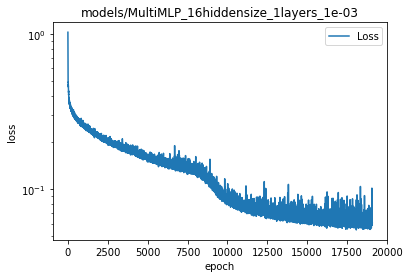

MultiMLP_16hiddensize_1layers_1e-03
Train accuracy = 0.9676, Test accuracy = 0.8254
VTE Train AUC = 0.9946, Test AUC = 0.8417
Death Train AUC = 0.9989, Test AUC = 0.8220
Epoch: 0, Loss: 1.0926e+00
Epoch: 100, Loss: 3.4798e-01
Epoch: 200, Loss: 3.3611e-01
Epoch: 300, Loss: 3.1480e-01
Epoch: 400, Loss: 2.9684e-01
Epoch: 500, Loss: 2.9450e-01
Epoch: 600, Loss: 2.8466e-01
Epoch: 700, Loss: 2.6353e-01
Epoch: 800, Loss: 2.5482e-01
Epoch: 900, Loss: 2.4846e-01
Epoch: 1000, Loss: 2.3080e-01
Epoch: 1100, Loss: 2.3111e-01
Epoch: 1200, Loss: 2.3171e-01
Epoch: 1300, Loss: 2.0973e-01
Epoch: 1400, Loss: 2.0335e-01
Epoch: 1500, Loss: 2.0200e-01
Epoch: 1600, Loss: 1.8817e-01
Epoch: 1700, Loss: 1.9863e-01
Epoch: 1800, Loss: 1.8224e-01
Epoch: 1900, Loss: 1.7383e-01
Epoch: 2000, Loss: 1.5790e-01
Epoch: 2100, Loss: 1.6964e-01
Epoch: 2200, Loss: 1.7730e-01
Epoch: 2300, Loss: 1.6657e-01
Epoch: 2400, Loss: 1.4429e-01
Epoch: 2500, Loss: 1.5016e-01
Epoch: 2600, Loss: 1.6599e-01
Epoch: 2700, Loss: 1.2943e-01
Ep

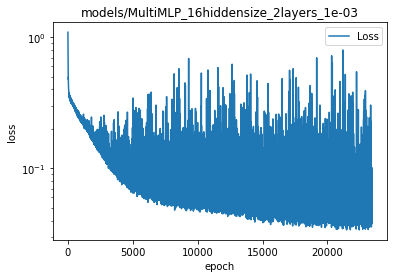

MultiMLP_16hiddensize_2layers_1e-03
Train accuracy = 0.9853, Test accuracy = 0.8119
VTE Train AUC = 0.9968, Test AUC = 0.8164
Death Train AUC = 1.0000, Test AUC = 0.8288
Epoch: 0, Loss: 1.1420e+00
Epoch: 100, Loss: 3.7143e-01
Epoch: 200, Loss: 3.3579e-01
Epoch: 300, Loss: 3.2159e-01
Epoch: 400, Loss: 3.1152e-01
Epoch: 500, Loss: 2.9171e-01
Epoch: 600, Loss: 2.7095e-01
Epoch: 700, Loss: 2.4024e-01
Epoch: 800, Loss: 2.1728e-01
Epoch: 900, Loss: 1.7192e-01
Epoch: 1000, Loss: 1.5609e-01
Epoch: 1100, Loss: 1.3523e-01
Epoch: 1200, Loss: 1.3000e-01
Epoch: 1300, Loss: 9.5035e-02
Epoch: 1400, Loss: 9.6729e-02
Epoch: 1500, Loss: 6.3708e-02
Epoch: 1600, Loss: 6.5170e-02
Epoch: 1700, Loss: 4.5982e-02
Epoch: 1800, Loss: 5.3034e-02
Epoch: 1900, Loss: 5.9528e-02
Epoch: 2000, Loss: 3.4299e-02
Epoch: 2100, Loss: 3.3146e-02
Epoch: 2200, Loss: 2.6998e-02
Epoch: 2300, Loss: 2.2948e-02
Epoch: 2400, Loss: 1.5648e-02
Epoch: 2500, Loss: 1.4585e-02
Epoch: 2600, Loss: 1.4442e-02
Epoch: 2700, Loss: 1.1179e-01
Ep

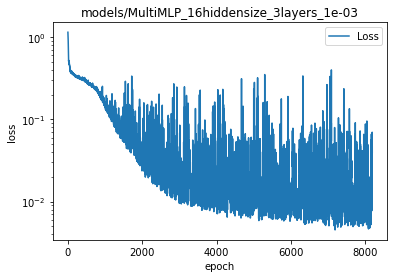

MultiMLP_16hiddensize_3layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8339
VTE Train AUC = 1.0000, Test AUC = 0.8420
Death Train AUC = 1.0000, Test AUC = 0.8099
Epoch: 0, Loss: 1.0050e+00
Epoch: 100, Loss: 3.4821e-01
Epoch: 200, Loss: 3.1883e-01
Epoch: 300, Loss: 3.0376e-01
Epoch: 400, Loss: 2.8836e-01
Epoch: 500, Loss: 2.9015e-01
Epoch: 600, Loss: 2.7674e-01
Epoch: 700, Loss: 2.7849e-01
Epoch: 800, Loss: 2.6516e-01
Epoch: 900, Loss: 2.6400e-01
Epoch: 1000, Loss: 2.5997e-01
Epoch: 1100, Loss: 2.5570e-01
Epoch: 1200, Loss: 2.5728e-01
Epoch: 1300, Loss: 2.4495e-01
Epoch: 1400, Loss: 2.3899e-01
Epoch: 1500, Loss: 2.3592e-01
Epoch: 1600, Loss: 2.3439e-01
Epoch: 1700, Loss: 2.3339e-01
Epoch: 1800, Loss: 2.3016e-01
Epoch: 1900, Loss: 2.2687e-01
Epoch: 2000, Loss: 2.2925e-01
Epoch: 2100, Loss: 2.2009e-01
Epoch: 2200, Loss: 2.2567e-01
Epoch: 2300, Loss: 2.2069e-01
Epoch: 2400, Loss: 2.1945e-01
Epoch: 2500, Loss: 2.1058e-01
Epoch: 2600, Loss: 2.0747e-01
Epoch: 2700, Loss: 2.0699e-01
Ep

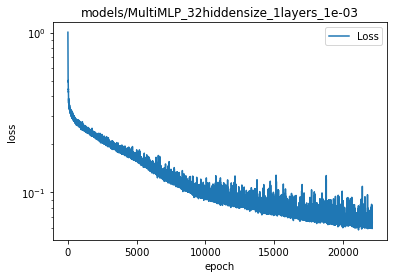

MultiMLP_32hiddensize_1layers_1e-03
Train accuracy = 0.9720, Test accuracy = 0.8508
VTE Train AUC = 0.9992, Test AUC = 0.8208
Death Train AUC = 0.9981, Test AUC = 0.8118
Epoch: 0, Loss: 9.4774e-01
Epoch: 100, Loss: 3.5939e-01
Epoch: 200, Loss: 3.2879e-01
Epoch: 300, Loss: 2.8976e-01
Epoch: 400, Loss: 2.7737e-01
Epoch: 500, Loss: 2.5383e-01
Epoch: 600, Loss: 2.3143e-01
Epoch: 700, Loss: 2.1345e-01
Epoch: 800, Loss: 1.9696e-01
Epoch: 900, Loss: 1.6705e-01
Epoch: 1000, Loss: 1.4939e-01
Epoch: 1100, Loss: 1.2839e-01
Epoch: 1200, Loss: 1.2218e-01
Epoch: 1300, Loss: 9.7483e-02
Epoch: 1400, Loss: 9.3732e-02
Epoch: 1500, Loss: 7.9997e-02
Epoch: 1600, Loss: 6.6160e-02
Epoch: 1700, Loss: 5.5365e-02
Epoch: 1800, Loss: 4.6483e-02
Epoch: 1900, Loss: 4.8589e-02
Epoch: 2000, Loss: 4.5124e-02
Epoch: 2100, Loss: 6.3426e-02
Epoch: 2200, Loss: 4.4595e-02
Epoch: 2300, Loss: 4.0354e-02
Epoch: 2400, Loss: 4.1446e-02
Epoch: 2500, Loss: 3.8916e-02
Epoch: 2600, Loss: 3.5743e-02
Epoch: 2700, Loss: 2.8534e-02
Ep

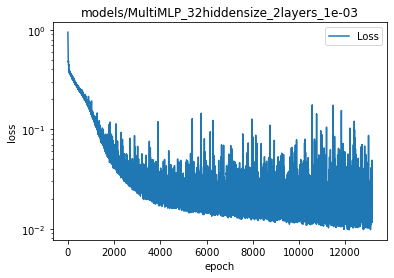

MultiMLP_32hiddensize_2layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8288
VTE Train AUC = 1.0000, Test AUC = 0.8092
Death Train AUC = 1.0000, Test AUC = 0.8347
Epoch: 0, Loss: 1.2234e+00
Epoch: 100, Loss: 3.8348e-01
Epoch: 200, Loss: 3.3605e-01
Epoch: 300, Loss: 3.1479e-01
Epoch: 400, Loss: 3.1526e-01
Epoch: 500, Loss: 2.9721e-01
Epoch: 600, Loss: 2.4757e-01
Epoch: 700, Loss: 2.0765e-01
Epoch: 800, Loss: 1.7777e-01
Epoch: 900, Loss: 1.5798e-01
Epoch: 1000, Loss: 1.3861e-01
Epoch: 1100, Loss: 1.3396e-01
Epoch: 1200, Loss: 1.3554e-01
Epoch: 1300, Loss: 1.3513e-01
Epoch: 1400, Loss: 1.3379e-01
Epoch: 1500, Loss: 9.6467e-02
Epoch: 1600, Loss: 1.0763e-01
Epoch: 1700, Loss: 8.9704e-02
Epoch: 1800, Loss: 7.4225e-02
Epoch: 1900, Loss: 6.2433e-02
Epoch: 2000, Loss: 5.9718e-02
Epoch: 2100, Loss: 6.2913e-02
Epoch: 2200, Loss: 5.4382e-02
Epoch: 2300, Loss: 4.3549e-02
Epoch: 2400, Loss: 3.6620e-02
Epoch: 2500, Loss: 3.8518e-02
Epoch: 2600, Loss: 5.0161e-02
Epoch: 2700, Loss: 8.5198e-02
Ep

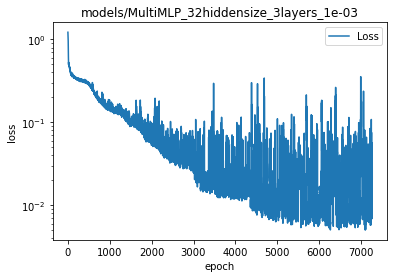

MultiMLP_32hiddensize_3layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8102
VTE Train AUC = 1.0000, Test AUC = 0.8238
Death Train AUC = 1.0000, Test AUC = 0.8145
Epoch: 0, Loss: 1.0707e+00
Epoch: 100, Loss: 3.5099e-01
Epoch: 200, Loss: 3.1737e-01
Epoch: 300, Loss: 3.0010e-01
Epoch: 400, Loss: 2.8132e-01
Epoch: 500, Loss: 2.7434e-01
Epoch: 600, Loss: 2.6914e-01
Epoch: 700, Loss: 2.6016e-01
Epoch: 800, Loss: 2.5383e-01
Epoch: 900, Loss: 2.4967e-01
Epoch: 1000, Loss: 2.4615e-01
Epoch: 1100, Loss: 2.4099e-01
Epoch: 1200, Loss: 2.3190e-01
Epoch: 1300, Loss: 2.2210e-01
Epoch: 1400, Loss: 2.2337e-01
Epoch: 1500, Loss: 2.1724e-01
Epoch: 1600, Loss: 2.1315e-01
Epoch: 1700, Loss: 2.1124e-01
Epoch: 1800, Loss: 2.1172e-01
Epoch: 1900, Loss: 1.9946e-01
Epoch: 2000, Loss: 2.0282e-01
Epoch: 2100, Loss: 1.9609e-01
Epoch: 2200, Loss: 1.9390e-01
Epoch: 2300, Loss: 1.8555e-01
Epoch: 2400, Loss: 1.8541e-01
Epoch: 2500, Loss: 1.7581e-01
Epoch: 2600, Loss: 1.7725e-01
Epoch: 2700, Loss: 1.7795e-01
Ep

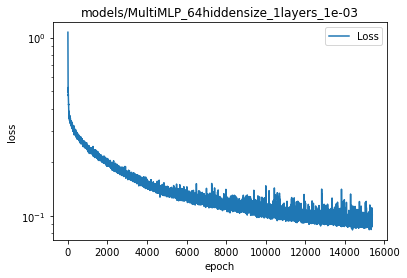

MultiMLP_64hiddensize_1layers_1e-03
Train accuracy = 0.9676, Test accuracy = 0.8508
VTE Train AUC = 0.9851, Test AUC = 0.8477
Death Train AUC = 0.9999, Test AUC = 0.8132
Epoch: 0, Loss: 1.0740e+00
Epoch: 100, Loss: 3.8003e-01
Epoch: 200, Loss: 3.4543e-01
Epoch: 300, Loss: 3.1301e-01
Epoch: 400, Loss: 2.8612e-01
Epoch: 500, Loss: 2.6433e-01
Epoch: 600, Loss: 2.5400e-01
Epoch: 700, Loss: 2.3206e-01
Epoch: 800, Loss: 2.2350e-01
Epoch: 900, Loss: 1.9007e-01
Epoch: 1000, Loss: 1.5430e-01
Epoch: 1100, Loss: 1.3317e-01
Epoch: 1200, Loss: 1.0957e-01
Epoch: 1300, Loss: 8.7127e-02
Epoch: 1400, Loss: 7.4614e-02
Epoch: 1500, Loss: 6.8120e-02
Epoch: 1600, Loss: 5.4864e-02
Epoch: 1700, Loss: 4.9268e-02
Epoch: 1800, Loss: 4.3614e-02
Epoch: 1900, Loss: 3.6442e-02
Epoch: 2000, Loss: 3.4107e-02
Epoch: 2100, Loss: 3.5808e-02
Epoch: 2200, Loss: 3.3639e-02
Epoch: 2300, Loss: 3.0957e-02
Epoch: 2400, Loss: 3.4170e-02
Epoch: 2500, Loss: 2.5488e-02
Epoch: 2600, Loss: 2.4096e-02
Epoch: 2700, Loss: 2.4403e-02
Ep

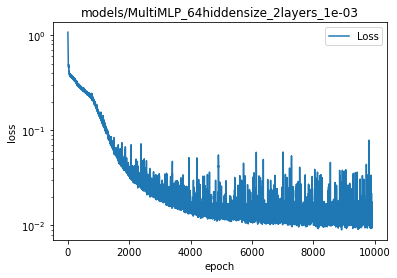

MultiMLP_64hiddensize_2layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8068
VTE Train AUC = 1.0000, Test AUC = 0.8187
Death Train AUC = 1.0000, Test AUC = 0.7896
Epoch: 0, Loss: 1.0518e+00
Epoch: 100, Loss: 3.6591e-01
Epoch: 200, Loss: 3.3707e-01
Epoch: 300, Loss: 3.1265e-01
Epoch: 400, Loss: 2.9026e-01
Epoch: 500, Loss: 2.5090e-01
Epoch: 600, Loss: 2.0616e-01
Epoch: 700, Loss: 1.7758e-01
Epoch: 800, Loss: 1.8393e-01
Epoch: 900, Loss: 1.6139e-01
Epoch: 1000, Loss: 1.6962e-01
Epoch: 1100, Loss: 1.6178e-01
Epoch: 1200, Loss: 1.6598e-01
Epoch: 1300, Loss: 1.5775e-01
Epoch: 1400, Loss: 1.4548e-01
Epoch: 1500, Loss: 1.4638e-01
Epoch: 1600, Loss: 1.4337e-01
Epoch: 1700, Loss: 1.3514e-01
Epoch: 1800, Loss: 1.3366e-01
Epoch: 1900, Loss: 1.2872e-01
Epoch: 2000, Loss: 1.2602e-01
Epoch: 2100, Loss: 1.2045e-01
Epoch: 2200, Loss: 1.1740e-01
Epoch: 2300, Loss: 1.1549e-01
Epoch: 2400, Loss: 1.2209e-01
Epoch: 2500, Loss: 1.1201e-01
Epoch: 2600, Loss: 1.0409e-01
Epoch: 2700, Loss: 1.3922e-01
Ep

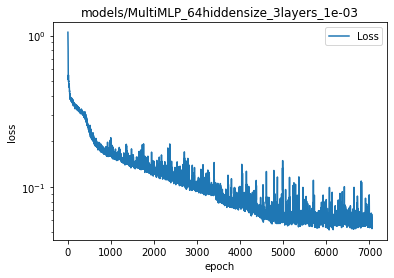

MultiMLP_64hiddensize_3layers_1e-03
Train accuracy = 0.9853, Test accuracy = 0.8017
VTE Train AUC = 0.9927, Test AUC = 0.8144
Death Train AUC = 0.9866, Test AUC = 0.8389
Epoch: 0, Loss: 1.0220e+00
Epoch: 100, Loss: 3.4375e-01
Epoch: 200, Loss: 3.2206e-01
Epoch: 300, Loss: 3.0484e-01
Epoch: 400, Loss: 2.9521e-01
Epoch: 500, Loss: 2.8060e-01
Epoch: 600, Loss: 2.7491e-01
Epoch: 700, Loss: 2.7218e-01
Epoch: 800, Loss: 2.5862e-01
Epoch: 900, Loss: 2.5461e-01
Epoch: 1000, Loss: 2.5523e-01
Epoch: 1100, Loss: 2.3861e-01
Epoch: 1200, Loss: 2.3448e-01
Epoch: 1300, Loss: 2.3639e-01
Epoch: 1400, Loss: 2.2251e-01
Epoch: 1500, Loss: 2.2382e-01
Epoch: 1600, Loss: 2.0738e-01
Epoch: 1700, Loss: 2.0962e-01
Epoch: 1800, Loss: 1.9876e-01
Epoch: 1900, Loss: 1.8803e-01
Epoch: 2000, Loss: 1.8370e-01
Epoch: 2100, Loss: 1.7378e-01
Epoch: 2200, Loss: 1.7742e-01
Epoch: 2300, Loss: 1.6375e-01
Epoch: 2400, Loss: 1.6295e-01
Epoch: 2500, Loss: 1.6287e-01
Epoch: 2600, Loss: 1.5350e-01
Epoch: 2700, Loss: 1.4636e-01
Ep

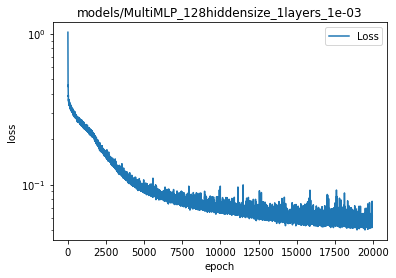

MultiMLP_128hiddensize_1layers_1e-03
Train accuracy = 0.9867, Test accuracy = 0.8475
VTE Train AUC = 0.9972, Test AUC = 0.8415
Death Train AUC = 1.0000, Test AUC = 0.8530
Epoch: 0, Loss: 1.0758e+00
Epoch: 100, Loss: 3.6027e-01
Epoch: 200, Loss: 3.3574e-01
Epoch: 300, Loss: 3.2803e-01
Epoch: 400, Loss: 3.0942e-01
Epoch: 500, Loss: 2.8780e-01
Epoch: 600, Loss: 2.7156e-01
Epoch: 700, Loss: 2.7402e-01
Epoch: 800, Loss: 2.4853e-01
Epoch: 900, Loss: 2.4431e-01
Epoch: 1000, Loss: 2.2935e-01
Epoch: 1100, Loss: 2.3296e-01
Epoch: 1200, Loss: 2.1543e-01
Epoch: 1300, Loss: 1.9622e-01
Epoch: 1400, Loss: 1.9728e-01
Epoch: 1500, Loss: 1.7766e-01
Epoch: 1600, Loss: 1.7177e-01
Epoch: 1700, Loss: 1.7100e-01
Epoch: 1800, Loss: 1.8267e-01
Epoch: 1900, Loss: 1.4690e-01
Epoch: 2000, Loss: 1.3660e-01
Epoch: 2100, Loss: 1.3868e-01
Epoch: 2200, Loss: 1.3271e-01
Epoch: 2300, Loss: 1.3125e-01
Epoch: 2400, Loss: 1.2416e-01
Epoch: 2500, Loss: 1.2928e-01
Epoch: 2600, Loss: 1.2863e-01
Epoch: 2700, Loss: 1.4169e-01
E

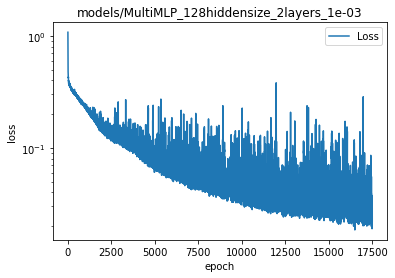

MultiMLP_128hiddensize_2layers_1e-03
Train accuracy = 0.9912, Test accuracy = 0.8237
VTE Train AUC = 0.9998, Test AUC = 0.8518
Death Train AUC = 1.0000, Test AUC = 0.7573
Epoch: 0, Loss: 1.0231e+00
Epoch: 100, Loss: 3.6069e-01
Epoch: 200, Loss: 3.3964e-01
Epoch: 300, Loss: 3.2945e-01
Epoch: 400, Loss: 3.1203e-01
Epoch: 500, Loss: 3.0308e-01
Epoch: 600, Loss: 2.7992e-01
Epoch: 700, Loss: 2.6308e-01
Epoch: 800, Loss: 2.3846e-01
Epoch: 900, Loss: 2.3261e-01
Epoch: 1000, Loss: 2.2017e-01
Epoch: 1100, Loss: 2.1964e-01
Epoch: 1200, Loss: 2.6032e-01
Epoch: 1300, Loss: 2.0402e-01
Epoch: 1400, Loss: 1.7799e-01
Epoch: 1500, Loss: 1.8369e-01
Epoch: 1600, Loss: 1.6113e-01
Epoch: 1700, Loss: 1.5285e-01
Epoch: 1800, Loss: 1.5672e-01
Epoch: 1900, Loss: 1.4277e-01
Epoch: 2000, Loss: 1.4902e-01
Epoch: 2100, Loss: 1.4434e-01
Epoch: 2200, Loss: 1.2031e-01
Epoch: 2300, Loss: 1.2164e-01
Epoch: 2400, Loss: 1.1536e-01
Epoch: 2500, Loss: 1.2167e-01
Epoch: 2600, Loss: 1.0049e-01
Epoch: 2700, Loss: 1.0540e-01
E

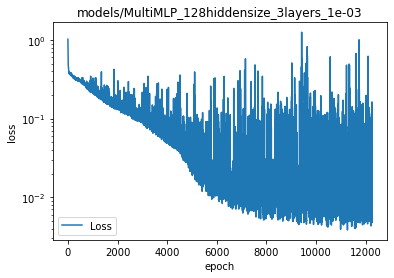

MultiMLP_128hiddensize_3layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8119
VTE Train AUC = 1.0000, Test AUC = 0.8036
Death Train AUC = 1.0000, Test AUC = 0.8246
Epoch: 0, Loss: 1.0627e+00
Epoch: 100, Loss: 3.3795e-01
Epoch: 200, Loss: 3.1482e-01
Epoch: 300, Loss: 2.9477e-01
Epoch: 400, Loss: 2.9514e-01
Epoch: 500, Loss: 2.7677e-01
Epoch: 600, Loss: 2.6995e-01
Epoch: 700, Loss: 2.6510e-01
Epoch: 800, Loss: 2.6782e-01
Epoch: 900, Loss: 2.5911e-01
Epoch: 1000, Loss: 2.5483e-01
Epoch: 1100, Loss: 2.4583e-01
Epoch: 1200, Loss: 2.4086e-01
Epoch: 1300, Loss: 2.3773e-01
Epoch: 1400, Loss: 2.2951e-01
Epoch: 1500, Loss: 2.2826e-01
Epoch: 1600, Loss: 2.1982e-01
Epoch: 1700, Loss: 2.1201e-01
Epoch: 1800, Loss: 2.1287e-01
Epoch: 1900, Loss: 1.9946e-01
Epoch: 2000, Loss: 1.8901e-01
Epoch: 2100, Loss: 1.7862e-01
Epoch: 2200, Loss: 1.6956e-01
Epoch: 2300, Loss: 1.6747e-01
Epoch: 2400, Loss: 1.6314e-01
Epoch: 2500, Loss: 1.5855e-01
Epoch: 2600, Loss: 1.6335e-01
Epoch: 2700, Loss: 1.5261e-01
E

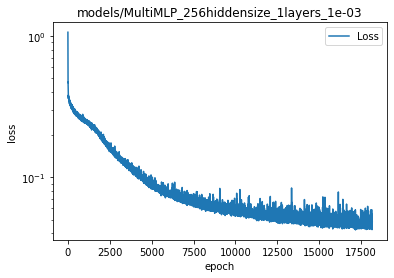

MultiMLP_256hiddensize_1layers_1e-03
Train accuracy = 0.9823, Test accuracy = 0.8305
VTE Train AUC = 0.9999, Test AUC = 0.8310
Death Train AUC = 0.9999, Test AUC = 0.8475
Epoch: 0, Loss: 9.4094e-01
Epoch: 100, Loss: 3.7852e-01
Epoch: 200, Loss: 3.3490e-01
Epoch: 300, Loss: 3.3027e-01
Epoch: 400, Loss: 3.0177e-01
Epoch: 500, Loss: 2.8639e-01
Epoch: 600, Loss: 2.6914e-01
Epoch: 700, Loss: 2.5430e-01
Epoch: 800, Loss: 2.4634e-01
Epoch: 900, Loss: 2.3416e-01
Epoch: 1000, Loss: 2.0840e-01
Epoch: 1100, Loss: 2.0238e-01
Epoch: 1200, Loss: 1.9500e-01
Epoch: 1300, Loss: 1.8680e-01
Epoch: 1400, Loss: 1.7178e-01
Epoch: 1500, Loss: 1.7124e-01
Epoch: 1600, Loss: 1.5470e-01
Epoch: 1700, Loss: 1.5186e-01
Epoch: 1800, Loss: 1.3748e-01
Epoch: 1900, Loss: 1.3165e-01
Epoch: 2000, Loss: 1.3033e-01
Epoch: 2100, Loss: 1.2181e-01
Epoch: 2200, Loss: 1.5218e-01
Epoch: 2300, Loss: 1.0110e-01
Epoch: 2400, Loss: 1.0426e-01
Epoch: 2500, Loss: 9.5699e-02
Epoch: 2600, Loss: 9.5122e-02
Epoch: 2700, Loss: 8.5226e-02
E

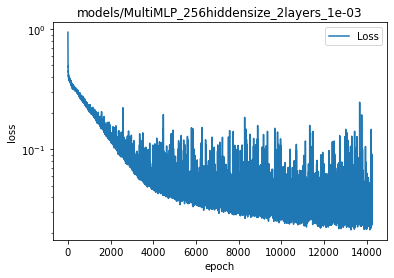

MultiMLP_256hiddensize_2layers_1e-03
Train accuracy = 0.9912, Test accuracy = 0.8322
VTE Train AUC = 0.9996, Test AUC = 0.8134
Death Train AUC = 1.0000, Test AUC = 0.7943
Epoch: 0, Loss: 1.0775e+00
Epoch: 100, Loss: 3.8258e-01
Epoch: 200, Loss: 3.3474e-01
Epoch: 300, Loss: 3.1949e-01
Epoch: 400, Loss: 2.7775e-01
Epoch: 500, Loss: 2.1524e-01
Epoch: 600, Loss: 1.8328e-01
Epoch: 700, Loss: 1.6146e-01
Epoch: 800, Loss: 1.5588e-01
Epoch: 900, Loss: 1.5163e-01
Epoch: 1000, Loss: 1.5610e-01
Epoch: 1100, Loss: 1.5215e-01
Epoch: 1200, Loss: 1.4959e-01
Epoch: 1300, Loss: 1.5060e-01
Epoch: 1400, Loss: 1.4865e-01
Epoch: 1500, Loss: 1.4546e-01
Epoch: 1600, Loss: 1.4509e-01
Epoch: 1700, Loss: 1.4391e-01
Epoch: 1800, Loss: 1.5015e-01
Epoch: 1900, Loss: 1.4376e-01
Epoch: 2000, Loss: 1.5490e-01
Epoch: 2100, Loss: 1.3969e-01
Epoch: 2200, Loss: 1.4278e-01
Epoch: 2300, Loss: 1.4691e-01
Epoch: 2400, Loss: 1.4358e-01
Epoch: 2500, Loss: 1.3692e-01
Epoch: 2600, Loss: 1.6178e-01
Epoch: 2700, Loss: 1.4341e-01
E

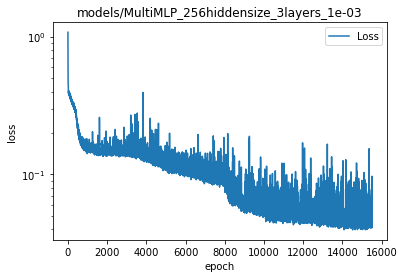

MultiMLP_256hiddensize_3layers_1e-03
Train accuracy = 0.9897, Test accuracy = 0.7797
VTE Train AUC = 0.9965, Test AUC = 0.8037
Death Train AUC = 0.9931, Test AUC = 0.8042


In [16]:
criterion = nn.CrossEntropyLoss()

for weight_decay in [1e-3]:
    for hidden_size in [16, 32, 64, 128, 256]:
        for num_layer in [1, 2, 3]:
            
            path = './models/MultiMLP_{}hiddensize_{}layers_{:.0e}'.format(hidden_size, num_layer, weight_decay)
            #if os.path.isfile(path):
            #    continue

            model = MLP(input_size=total_train.shape[-1], hidden_size=hidden_size, num_layer=num_layer, num_event=num_event).to(device)
            #if os.path.isfile(path):
            #    model.load_state_dict(torch.load(path, map_location = device))

            lr = 1e-3
            optimizer = adabound.AdaBound(model.parameters(), lr=lr, weight_decay=0)

            loss_array = []
            patience = 0
            min_loss = np.inf
            for e in range(int(1e6)):

                loss_array_tmp = []

                for total_batch, timevar_compact_batch, event_batch, time_batch, obs_mask_batch in train_loader:

                    total_batch = total_batch.float()
                    event_batch = event_batch.long()

                    y_pred = model(total_batch.to(device))

                    norm = 0.
                    for parameter in model.parameters():
                        norm += torch.norm(parameter, p=1)

                    loss1 = criterion(y_pred, event_batch.to(device))

                    loss = loss1 + weight_decay*norm
                    loss_array_tmp.append(loss1.item())

                    model.zero_grad()

                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                loss_array.append(np.mean(loss_array_tmp))
                if e % 100 == 0:
                    print('Epoch: ' + str(e) + 
                          ', Loss: '+ f'{loss_array[-1]:.4e}')
                if min_loss > loss_array[-1]:
                    patience = 0
                    min_loss = loss_array[-1]
                    torch.save(model.state_dict(), path)
                else:
                    patience += 1

                torch.cuda.empty_cache()

                if patience > 1000:
                    break

            plt.plot(loss_array, label='Loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.yscale('log')
            plt.title(path[2:])
            plt.legend()
            plt.show()

            total_train_sort = torch.FloatTensor(total_train)
            total_test_sort = torch.FloatTensor(total_test)

            model.load_state_dict(torch.load(path, map_location = device))

            y_train = torch.softmax(model(total_train_sort.to(device)), 1).detach().cpu().numpy()
            y_test = torch.softmax(model(total_test_sort.to(device)), 1).detach().cpu().numpy()

            out_pred = np.where(y_train >= 0.5, 1, 0)
            acc_train = accuracy_score(event_train, out_pred.argmax(1))
            auc_train_vte = roc_auc_score(event_train == 1, y_train[:,1])
            auc_train_death = roc_auc_score(event_train == 2, y_train[:,2])
            
            out_pred = np.where(y_test >= 0.5, 1, 0)
            acc_test = accuracy_score(event_test, out_pred.argmax(1))
            auc_test_vte = roc_auc_score(event_test == 1, y_test[:,1])
            auc_test_death = roc_auc_score(event_test == 2, y_test[:,2])
            
            print(path[9:])
            print('Train accuracy = {:.4f}, Test accuracy = {:.4f}'.format(acc_train, acc_test))
            print('VTE Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train_vte, auc_test_vte))
            print('Death Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train_death, auc_test_death))
            
                   

In [17]:
for weight_decay in [1e-3]:
    for hidden_size in [16, 32, 64, 128, 256]:
        for num_layer in [1, 2, 3]:

            path = './models/MultiMLP_{}hiddensize_{}layers_{:.0e}'.format(hidden_size, num_layer, weight_decay)
            #if os.path.isfile(path):
            #    continue

            model = MLP(input_size=total_train.shape[-1], hidden_size=hidden_size, num_layer=num_layer, num_event=num_event).to(device)
            if os.path.isfile(path):
                model.load_state_dict(torch.load(path, map_location = device))

            total_train_sort = torch.FloatTensor(total_train)
            total_test_sort = torch.FloatTensor(total_test)

            model.load_state_dict(torch.load(path, map_location = device))

            y_train = torch.softmax(model(total_train_sort.to(device)),1).detach().cpu().numpy()
            y_test = torch.softmax(model(total_test_sort.to(device)),1).detach().cpu().numpy()            

            out_pred = np.where(y_train >= 0.5, 1, 0)
            acc_train = accuracy_score(event_train, out_pred.argmax(1))
            auc_train_vte = roc_auc_score(event_train == 1, y_train[:,1])
            auc_train_death = roc_auc_score(event_train == 2, y_train[:,2])
            
            out_pred = np.where(y_test >= 0.5, 1, 0)
            acc_test = accuracy_score(event_test, out_pred.argmax(1))
            auc_test_vte = roc_auc_score(event_test == 1, y_test[:,1])
            auc_test_death = roc_auc_score(event_test == 2, y_test[:,2])
            
            print(path[9:])
            print('Train accuracy = {:.4f}, Test accuracy = {:.4f}'.format(acc_train, acc_test))
            print('VTE Train AUC = {:.4f}, Test AUC = {:.4f}\n'.format(auc_train_vte, auc_test_vte))
            #print('Death Train AUC = {:.4f}, Test AUC = {:.4f}\n'.format(auc_train_death, auc_test_death))

MultiMLP_16hiddensize_1layers_1e-03
Train accuracy = 0.9676, Test accuracy = 0.8254
VTE Train AUC = 0.9946, Test AUC = 0.8417

MultiMLP_16hiddensize_2layers_1e-03
Train accuracy = 0.9853, Test accuracy = 0.8119
VTE Train AUC = 0.9968, Test AUC = 0.8164

MultiMLP_16hiddensize_3layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8339
VTE Train AUC = 1.0000, Test AUC = 0.8420

MultiMLP_32hiddensize_1layers_1e-03
Train accuracy = 0.9720, Test accuracy = 0.8508
VTE Train AUC = 0.9992, Test AUC = 0.8208

MultiMLP_32hiddensize_2layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8288
VTE Train AUC = 1.0000, Test AUC = 0.8092

MultiMLP_32hiddensize_3layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8102
VTE Train AUC = 1.0000, Test AUC = 0.8238

MultiMLP_64hiddensize_1layers_1e-03
Train accuracy = 0.9676, Test accuracy = 0.8508
VTE Train AUC = 0.9851, Test AUC = 0.8477

MultiMLP_64hiddensize_2layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8068
VTE Train AUC = 1.0000, Tes

In [18]:
for weight_decay in [1e-3]:
    for hidden_size in [64]:
        for num_layer in [3]:

            path = './models/MultiMLP_{}hiddensize_{}layers_{:.0e}'.format(hidden_size, num_layer, weight_decay)
            #if os.path.isfile(path):
            #    continue

            model = MLP(input_size=total_train.shape[-1], hidden_size=hidden_size, num_layer=num_layer, num_event=num_event).to(device)
            if os.path.isfile(path):
                model.load_state_dict(torch.load(path, map_location = device))

            total_train_sort = torch.FloatTensor(total_train)
            total_test_sort = torch.FloatTensor(total_test)

            model.load_state_dict(torch.load(path, map_location = device))

            y_train = torch.softmax(model(total_train_sort.to(device)),1).detach().cpu().numpy()
            y_test = torch.softmax(model(total_test_sort.to(device)),1).detach().cpu().numpy()            

            out_pred = np.where(y_train >= 0.5, 1, 0)
            acc_train = accuracy_score(event_train, out_pred.argmax(1))
            auc_train_vte = roc_auc_score(event_train == 1, y_train[:,1])
            auc_train_death = roc_auc_score(event_train == 2, y_train[:,2])
            
            out_pred = np.where(y_test >= 0.5, 1, 0)
            acc_test = accuracy_score(event_test, out_pred.argmax(1))
            auc_test_vte = roc_auc_score(event_test == 1, y_test[:,1])
            auc_test_death = roc_auc_score(event_test == 2, y_test[:,2])
            
            print(path[9:])
            print('Train accuracy = {:.4f}, Test accuracy = {:.4f}'.format(acc_train, acc_test))
            print('VTE Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train_vte, auc_test_vte))
            #print('Death Train AUC = {:.4f}, Test AUC = {:.4f}\n'.format(auc_train_death, auc_test_death))

datestr =  str(datetime.date.today())
pd.DataFrame(np.stack([y_train[:,1], event_train], 1), columns=['Predicted', 'Event']).to_csv('./Results/MultiMLP_VTE_Train_{}hiddensize_{}layers_{}.csv'.format(hidden_size, num_layer, datestr))
pd.DataFrame(np.stack([y_test[:,1], event_test], 1), columns=['Predicted', 'Event']).to_csv('./Results/MultiMLP_VTE_Test_{}hiddensize_{}layers_{}.csv'.format(hidden_size, num_layer, datestr))

MultiMLP_64hiddensize_3layers_1e-03
Train accuracy = 0.9853, Test accuracy = 0.8017
VTE Train AUC = 0.9927, Test AUC = 0.8144
